# **Prediction with Regression**

## Objectives

* Fit and evaluate a regression model to predict Students Exam Score.

## Inputs

* outputs/datasets/collection/StudentPerformance.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Exam Score
* labels map
* Feature Importance Plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Student-Performance'

-----

# Load data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/StudentPerformance.csv")
      )

print(df.shape)
df.head(3)

(6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74


---

# ML Pipline: Regressor

## Create ML pipeline 

In [5]:
from sklearn.pipeline import Pipeline

# Cleaning
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.discretisation import EqualFrequencyDiscretiser 

# Feat Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [96]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


---

## Split Train and Test Set

In [11]:
from sklearn.model_selection import train_test_split
X = df.drop(['Exam_Score'], axis=1) # Defining the features
y = df['Exam_Score'] # Defining the the target for the prediction

X_train, X_test, y_train, y_test = train_test_split(
     X,
     y,
     test_size=0.2,
     random_state=0
 )

print("* Train set:", X_train.shape, y_train.shape,
       "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (5285, 19) (5285,) 
* Test set: (1322, 19) (1322,)


## Grid Search CV - Sklearn

In [99]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}


params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [100]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Checking the resulte

In [61]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.494062,0.641766,0.764155,0.089603
5,GradientBoostingRegressor,0.443837,0.551627,0.652642,0.071278
6,XGBRegressor,0.407407,0.516318,0.611245,0.070621
2,RandomForestRegressor,0.338651,0.481695,0.607583,0.087903
3,ExtraTreesRegressor,0.281325,0.382418,0.52964,0.095395
1,DecisionTreeRegressor,-0.027753,0.112576,0.245693,0.106021
4,AdaBoostRegressor,-1.194011,-0.455568,0.343277,0.563316


Since LinearRegssion doesn't have so many hyperparameter, the model GradientBoostRegressor will also be explored to see if the Model be improved.

In [110]:
models_search = {
    # 'LinearRegression': LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    # 'LinearRegression': {
    #     'model__positive': [True, False],
    #     'model__n_jobs':[None, 1, 2]
    # },
    "GradientBoostingRegressor": {
        # Balanced preformance and speed
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.1, 0.05],
        "model__max_depth": [3, 5],
        "model__subsample": [0.8, 1.0],
        "model__max_features": ["sqrt"],
        "model__random_state": [42],
        # Best score 0.55

        # # Minimizing overfitting
        # "model__n_estimators": [200, 500],
        # "model__learning_rate": [0.01, 0.05],
        # "model__max_depth": [3, 5],
        # "model__min_samples_split": [10, 20],
        # "model__min_samples_leaf": [5, 10],
        # "model__subsample": [0.7, 0.8],
        # "model__max_features": [0.5],
        # "model__random_state": [42],
        # # Best score 0.55

        # # Higher complexity and model flexibility
        # "model__n_estimators": [500, 1000],
        # "model__learning_rate": [0.01, 0.05],
        # "model__max_depth": [5, 7],
        # "model__subsample": [0.8],
        # "model__max_features": ["auto", 0.8],
        # "model__min_samples_leaf": [1, 3],
        # "model__random_state": [42],
        # # Best score 0.54
    },
    
}

In [111]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)  


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [109]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_features,model__min_samples_leaf,model__n_estimators,model__random_state,model__subsample
6,GradientBoostingRegressor,0.437453,0.545879,0.652586,0.073,0.01,5,0.8,3,500,42,0.8
4,GradientBoostingRegressor,0.434081,0.542963,0.648307,0.073222,0.01,5,0.8,1,500,42,0.8
7,GradientBoostingRegressor,0.426214,0.531899,0.638376,0.072399,0.01,5,0.8,3,1000,42,0.8
5,GradientBoostingRegressor,0.421778,0.523654,0.623496,0.070993,0.01,5,0.8,1,1000,42,0.8
14,GradientBoostingRegressor,0.414797,0.511736,0.620173,0.070971,0.01,7,0.8,3,500,42,0.8
22,GradientBoostingRegressor,0.398175,0.504481,0.614243,0.074028,0.05,5,0.8,3,500,42,0.8
12,GradientBoostingRegressor,0.39489,0.489123,0.59523,0.074373,0.01,7,0.8,1,500,42,0.8
20,GradientBoostingRegressor,0.385401,0.487622,0.584615,0.072582,0.05,5,0.8,1,500,42,0.8
15,GradientBoostingRegressor,0.388818,0.483938,0.595985,0.073195,0.01,7,0.8,3,1000,42,0.8
23,GradientBoostingRegressor,0.364844,0.475304,0.585708,0.077231,0.05,5,0.8,3,1000,42,0.8


### Quick Conclusion

To find a model with a mean score of at least 0.8, as specified in the business case, the data underwent cleaning and feature engineering, which were detailed in previous notebooks. Various models were tested, and it was observed that the model with the highest mean score was LinearRegression, achieving approximately 0.64, followed by GradientBoostingRegressor with a score of around 0.55. 

Due to LinearRegression having very few hyperparameters, GradientBoostingRegressor was also explored to see if its performance could be enhanced through hyperparameter tuning. In the first attempt to improve the model using hyperparameters, it was evident that LinearRegression still maintained the highest mean score, although there was no improvement in the score itself. 

In the second attempt, the LinearRegression model was removed, and more hyperparameters were introduced to assess potential improvements. However, the results indicated that LinearRegression continued to have the best mean score.

**Score for the LinearRegresson and the quick search**
|estimator | min_score | mean_score | max_score | std_score | 
|:----     |----       |----        |----       |----       |
|LinearRegression |	0.494062 | 0.641766 | 0.764155 | 0.089603 |

**Attempt two to improve the model with the hyperparameters**
|no. |estimator | min_score | mean_score | max_score | std_score | 
|:---|:----     |----       |----        |----       |----       |
|1242 | GradientBoostingRegressor | 0.446847 | 0.556504 | 0.663426 | 0.072982 |
|1134 | GradientBoostingRegressor | 0.446847 | 0.556504 | 0.663426 |	0.072982 |	
|1260 | GradientBoostingRegressor | 0.44674  | 0.556464 | 0.663597 | 0.073082 |	
|1152 | GradientBoostingRegressor | 0.44674  | 0.556464 | 0.663597 |	0.073082 |	
|1251 | GradientBoostingRegressor | 0.44674 | 0.556446 | 0.663411 | 0.073031 |

The next step is to explore if the model will have a better result with the NaN values replaced with the most frequent values.


## Create ML pipeline with Missing values to most fequent

In [18]:
from feature_engine.imputation import CategoricalImputer, DropMissingData

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                   variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [ ]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.530141,0.630419,0.690003,0.053237
5,GradientBoostingRegressor,0.429427,0.547969,0.624965,0.064219
6,XGBRegressor,0.355214,0.493917,0.576832,0.078367
2,RandomForestRegressor,0.403796,0.458818,0.51495,0.036278
3,ExtraTreesRegressor,0.343208,0.398857,0.468127,0.04184
1,DecisionTreeRegressor,-0.161578,0.024558,0.188947,0.147951
4,AdaBoostRegressor,-0.172119,-0.021568,0.20844,0.134745


### Quick Conclusion

In this section, we replaced the missing values with the most frequent value for each specific feature, instead of labeling them as 'Missing'. This approach aimed to improve the model's performance. We tested various models; however, further investigation with hyperparameters was determined to be unnecessary. The results showed that changing the NaN values to the most frequent values in the features had no significant impact. Since there were no major differences observed, the subsequent tests will use the method of replacing NaN values with 'Missing'.

The next step in this notebook is to explore a model called KNeighborsRegressor.

## Create Pipline modified for KNeighborsRegressor

The KNeighborsRegressor is a non-parametric regression method that predicts values based on the k closest training data points. It stores the training data and uses a distance metric, usually Euclidean distance, to make predictions.

For each prediction, the average of the target values of the k nearest points is calculated. This can be done with uniform weighting or by considering distance. Choosing the right value for k is crucial: smaller values may result in high variance, while larger values can lead to high bias. Therefore, the function below examines the optimal k-value, along with the mean R² value.

In [24]:
def PipelineOptimization_KNN(model):
    steps = [
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),
        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        ("YeoJohnson", YeoJohnsonTransformer(['Attendance', 'Tutoring_Sessions'])),
        ("feat_scaling", StandardScaler())
    ]
    
    # Add feature selection step only if the model has feature_importances_ or coef_ attributes
    if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))
    
    pipeline_base = Pipeline(steps)
    return pipeline_base

The max value is 0.4677504653592591 and as the k-value 19


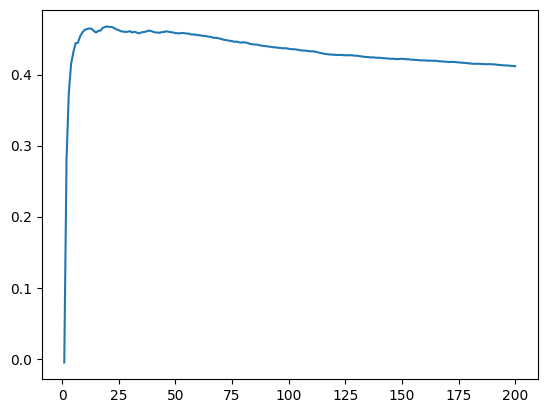

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


def Predict_k_value(X_train, y_train, X_test, y_test, k_max):
    knn_r_score=[]

    for i in range(1, k_max):
        # Create and fit the KNeighborsRegressor
        knn_pipeline = PipelineOptimization_KNN(KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree'))
        knn_pipeline.fit(X_train, y_train)

        # Predict on the test data
        y_pred = knn_pipeline.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        knn_r_score.append(r2)

    print(f'The max value is {max(knn_r_score)} and as the k-value {knn_r_score.index(max(knn_r_score))}')
    plt.plot(range(1, k_max), knn_r_score)
    plt.show

Predict_k_value(X_train, y_train, X_test, y_test, 201)

### Quick Conclusion

As previously discussed, an alternative approach was attempted to improve the model. In this case, the KNeighborsRegressor model was utilized, and a function was created to determine the optimal k value. The most suitable k-value found was 19, however, the mean score for the R² value was approximately 0.47, which is much lower than the scores obtained in previous sections.

In the next section, a pipeline will be developed using PCA to enhance the model.

## Create ML Pipline with PCA

In [8]:
df = (pd.read_csv("outputs/datasets/collection/StudentPerformance.csv")
      )

In [62]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [63]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:4])
df_pca = pipeline_pca.fit_transform(df.drop(['Exam_Score'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(6607, 19) 
 <class 'numpy.ndarray'>


* The 19 components explain 100.0% of the data 



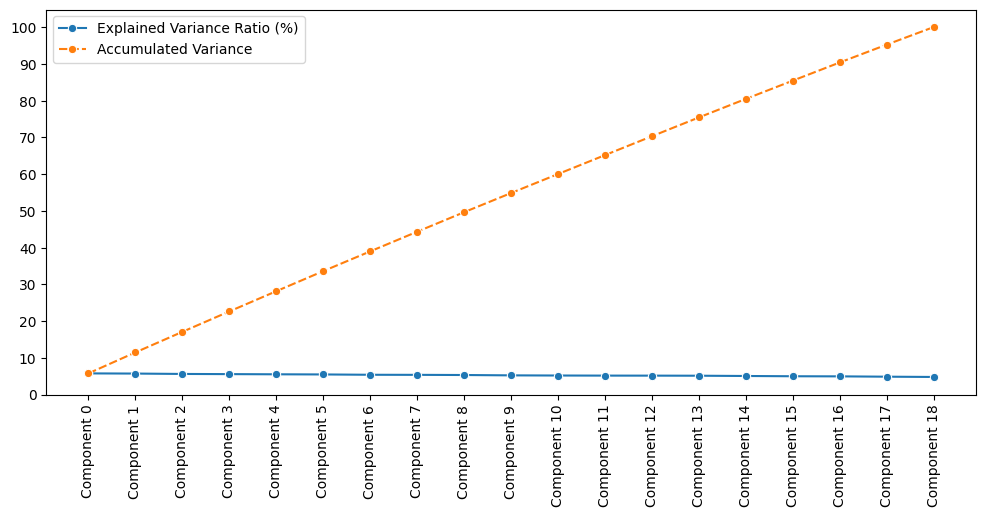

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_components = 19


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 7 components explain 95.59% of the data 



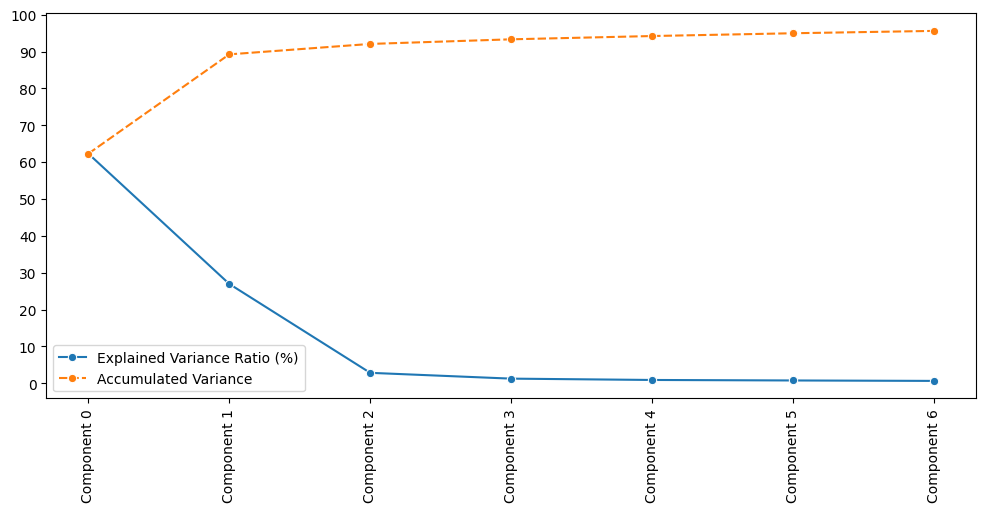

In [48]:
n_components = 18
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipline for Modelling

In [65]:
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                                'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                                'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                                'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", Normalizer()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=18, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

In [35]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (5285, 19) (5285,) 
* Test set: (1322, 19) (1322,)


In [66]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [67]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
6,XGBRegressor,0.436429,0.554281,0.673672,0.082537
5,GradientBoostingRegressor,0.385005,0.524784,0.665162,0.097764
3,ExtraTreesRegressor,0.369829,0.483128,0.641509,0.092812
2,RandomForestRegressor,0.341308,0.465052,0.625018,0.09786
0,LinearRegression,0.248031,0.288895,0.325384,0.027142
1,DecisionTreeRegressor,-0.50379,-0.249968,0.081475,0.19295
4,AdaBoostRegressor,-0.788112,-0.463118,0.023938,0.270675


### Quick Conclusion

**Rewrite this text**
The model was not approved by training the model with PCA . It can also be seen that all of the components is needed to be close to the mean score in that can be find in the first attempt. 

Next step, Try to improve the model by using a classifier insted of a regresson.

-------

## Recreate Pipline and tagets to Classification

In [19]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                    fill_value='Missing',
                                                    variables=['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'])),

        ("Ordinal_Encoder", OrdinalEncoder(encoding_method='arbitrary',
                                           variables=['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                                                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                                                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                                                      'Distance_from_Home', 'Gender'])),
        
        ("YeoJohnson", YeoJohnsonTransformer(variables=['Attendance', 'Tutoring_Sessions'])),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

def PipelineCleaning(q):
    pipline_cleaned = Pipeline([
        ('efd', EqualFrequencyDiscretiser(q=q, variables=['Exam_Score'] ))
    ])
    return pipline_cleaned

In [42]:
def find_query_size(df, PipelineCleaning):
    """
    This funsction find the number of querys the Dataframe should be
    devided in to have the least amount of diffrens between the number 
    of datapoints in the querys.

    return: int
            The number in querys 

    """

    max_diff_list = []

    for i in range(2,14):
        pipeline_taget_cleaning = PipelineCleaning(i)
        df_target_bins = pipeline_taget_cleaning.fit_transform(df)
        max_diff = df_target_bins['Exam_Score'].value_counts().max()- df_target_bins['Exam_Score'].value_counts().min()

        max_diff_list.append(max_diff)
    
    print(f'The nummer of {max_diff_list.index(min(max_diff_list))+2} bins with the lowest max diffrens, that is {min(max_diff_list)}.')
    
    return max_diff_list.index(min(max_diff_list))+2

find_query_size(df, PipelineCleaning)

The nummer of 5 bins with the lowest max diffrens, that is 393.


5

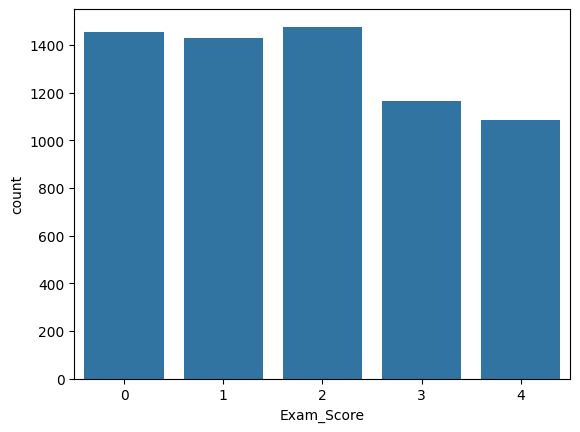

* Train set: (5285, 19) (5285,) 
* Test set: (1322, 19) (1322,)
{'Exam_Score': [-inf, 64.0, 66.0, 68.0, 70.0, inf]}


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

pipeline_taget_cleaning = PipelineCleaning(5)

df_target_bins = pipeline_taget_cleaning.fit_transform(df)

target_span = pipeline_taget_cleaning['efd'].binner_dict_

sns.countplot(data=df_target_bins, x='Exam_Score')
plt.show()


X = df_target_bins.drop(['Exam_Score'], axis=1) # Defining the features
y = df_target_bins['Exam_Score'] # Defining the the target for the prediction

X_train, X_test, y_train, y_test = train_test_split(
     X,
     y,
     test_size=0.2,
     random_state=0
 )

print("* Train set:", X_train.shape, y_train.shape,
       "\n* Test set:",  X_test.shape, y_test.shape)
print(target_span)

In [114]:
# ML algorithms
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [ ]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)

### Quick Conclusion
Text

# Optimize ML


In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

In [ ]:
grid_search_pipelines[best_model].best_params_

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
